In [132]:
import os
import math
from math import sqrt

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [133]:
EPS = 1.e-7

### Dataset

I use the MNIST Digits dataset. It consists of ~60000 training images of size 28x28.

The goal of using this dataset is that everyone can run it on a laptop, without the use of a cloud provider.

In [134]:
triain_img_path = "MNIST_FASHION\\train-images-idx3-ubyte"
train_label_path = "MNIST_FASHION\\train-labels-idx1-ubyte"
test_img_path = "MNIST_FASHION\\t10k-images-idx3-ubyte"
test_label_path = "MNIST_FASHION\\t10k-labels-idx1-ubyte"

with open(train_label_path, 'rb') as lbpath:
    train_labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with open(triain_img_path, 'rb') as imgpath:
    train_images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)


with open(test_label_path, 'rb') as lbpath:
    test_labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with open(test_img_path, 'rb') as imgpath:
    test_images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)
    

train_file_list = train_images[:4000]
valid_file_list = train_images[4000:4800]
test_file_list = test_images[:100]

img_size = (28, 28)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_size)),])

class ImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        image = self.file_list[index]
        image = np.array(image).astype(np.float32)
        # image = Image.open(self.file_list[index])
        # if self.transform is not None:
        #     image = self.transform(image)

        
        # image = np.array(image).astype(np.float32)
        # image = image.flatten()
        #print(image)

        #return image
        return torch.from_numpy(image).to(device)

### Auxiliary code

Auxiliary code for running some parts, e.g., Causal Convolution 1D for the autoregressive model (ARM).

**Causal Convolution for ARM**

In [135]:
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # attributes:
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        
        self.padding = (kernel_size - 1) * dilation + A * 1

        # module:
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation,
                                      **kwargs)

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:, :, : -1]
        else:
            return conv1d_out

**Quantizer**

The quantizer is the crucial component of a neural compressor. It consists of a codebook, a vector of floats. It takes a real-valued input and replaces them with the closests values in the codebook.
Please note that we use a real-valued codebook, however, in practice, we can implement it using integers. As a result, we use $K$ bits.

In [136]:
class Quantizer(nn.Module):
    def __init__(self, input_dim, codebook_dim, temp=1.e7):
        super(Quantizer, self).__init__()
        
        #temperature for softmax
        self.temp = temp
        
        # dimensionality of the inputs and the codebook
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        
        # codebook layer (a codebook)
        # - we initialize it uniformly
        # - we make it Parameter, namely, it is learnable
        self.codebook = nn.Parameter(torch.FloatTensor(1, self.codebook_dim,).uniform_(-1/self.codebook_dim, 1/self.codebook_dim))
    
    # A function for codebook indices (a one-hot representation) to values in the codebook.
    def indices2codebook(self, indices_onehot):
        return torch.matmul(indices_onehot, self.codebook.to(indices_onehot.device).t()).squeeze()
    
    # A function to change integers to a one-hot representation.
    def indices_to_onehot(self, inputs_shape, indices):
        indices_hard = torch.zeros(inputs_shape[0], inputs_shape[1], self.codebook_dim, device=indices.device)
        indices_hard.scatter_(2, indices, 1)
        return indices_hard
    
    # The forward function:
    # - First, distances are calculated between input values and codebook values.
    # - Second, indices (soft - differentiable, hard - non-differentiable) between the encoded values and the codebook values are calculated.
    # - Third, the quantizer returns indices and quantized code (the output of the encoder).
    # - Fourth, the decoder maps the quantized code to the obeservable space (i.e., it decodes the code back).
    def forward(self, inputs):
        # inputs - a matrix of floats, B x M
        inputs_shape = inputs.shape
        codebook = self.codebook.to(inputs.device)
        # repeat inputs
        inputs_repeat = inputs.unsqueeze(2).repeat(1, 1, self.codebook_dim)
        # calculate distances between input values and the codebook values
        distances = torch.exp(-torch.sqrt(torch.pow(inputs_repeat - self.codebook.unsqueeze(1), 2)))
        
        # indices (hard, i.e., nondiff)
        indices = torch.argmax(distances, dim=2).unsqueeze(2)
        indices_hard = self.indices_to_onehot(inputs_shape=inputs_shape, indices=indices)
        
        # indices (soft, i.e., diff)
        indices_soft = torch.softmax(self.temp * distances, -1)
        
        # quantized values: we use soft indices here because it allows backpropagation
        quantized = self.indices2codebook(indices_onehot=indices_soft)
        
        return (indices_soft, indices_hard, quantized)

**Encoder**

In [137]:
# The encoder is simply a neural network that takes an image and outputs a corresponding code.
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

    def encode(self, x):
        h_e = self.encoder(x)
        return h_e
    
    def forward(self, x):
        return self.encode(x)

**Decoder**

In [138]:
# The decoder is simply a neural network that takes a quantized code and returns an image.
class Decoder(nn.Module):
    def __init__(self, decoder_net):
        super(Decoder, self).__init__()

        self.decoder = decoder_net

    def decode(self, z):
        h_d = self.decoder(z)
        return h_d

    def forward(self, z, x=None):
        x_rec = self.decode(z)
        return x_rec

**Entropy Coding**

Entropy coding is the crucial step in the compression scheme. At this point, we have a quantized code that we want to transmit. In order to send the quantized code, which is typically represented by discerete (non-binary) symbols, it must be translated into a bitstream (a stream o bits).

An entropy coder assigns a unique prefix-free code (e.g., unique binary codes like Huffman codes) to each unique symbol that occurs in the input. Two of the most common entropy encoding techniques are Huffman coding and arithmetic coding that require knowing the (estimates of) probabilities of the symbols.

In [139]:
class UniformEntropyCoding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(UniformEntropyCoding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        
        self.probs = torch.softmax(torch.ones(1, self.code_dim, self.codebook_dim), -1)
    
    def sample(self, quantizer=None, B=10):
        code = torch.zeros(B, self.code_dim, self.codebook_dim)
        for b in range(B):
            indx = torch.multinomial(torch.softmax(self.probs, -1).squeeze(0), 1).squeeze()
            for i in range(self.code_dim):
                code[b,i,indx[i]] = 1
        
        code = quantizer.indices2codebook(code)
        return code
    
    def forward(self, z, x=None):
        p = torch.clamp(self.probs, EPS, 1. - EPS)
        return -torch.sum(z * torch.log(p), 2)

In [140]:
class IndependentEntropyCoding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(IndependentEntropyCoding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        
        self.probs = nn.Parameter(torch.ones(1, self.code_dim, self.codebook_dim))
    
    def sample(self, quantizer=None, B=10):
        code = torch.zeros(B, self.code_dim, self.codebook_dim)
        for b in range(B):
            indx = torch.multinomial(torch.softmax(self.probs, -1).squeeze(0), 1).squeeze()
            for i in range(self.code_dim):
                code[b,i,indx[i]] = 1
        
        code = quantizer.indices2codebook(code)
        return code
    
    def forward(self, z, x=None):
        p = torch.clamp(torch.softmax(self.probs, -1), EPS, 1. - EPS)
        return -torch.sum(z * torch.log(p), 2)

In [141]:
class ARMEntropyCoding(nn.Module):
    def __init__(self, code_dim, codebook_dim, arm_net):
        super(ARMEntropyCoding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        self.arm_net = arm_net # it takes B x 1 x code_dim and outputs B x codebook_dim x code_dim
    
    def f(self, x):
        device = next(self.parameters()).device
        x = x.to(device)
        h = self.arm_net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        
        return p
    
    def sample(self, quantizer=None, B=10):
        device = next(self.arm_net.parameters()).device
        x_new = torch.zeros((B, self.code_dim), device=device)
        
        for d in range(self.code_dim):
            p = self.f(x_new)
            indx_d = torch.multinomial(p[:, d, :], num_samples=1)
            codebook_value = quantizer.codebook[0, indx_d].squeeze().to(device)
            x_new[:, d] = codebook_value
        
        return x_new

    def forward(self, z, x):
        p = self.f(x)
        return -torch.sum(z * torch.log(p), 2)

**Full Neural Compressor**

In [142]:
class NeuralCompressor(nn.Module):
    def __init__(self, encoder, decoder, entropy_coding, quantizer, beta=1., detaching=False):
        super(NeuralCompressor, self).__init__()

        # we 
        self.encoder = encoder
        self.decoder = decoder
        self.entropy_coding = entropy_coding
        self.quantizer = quantizer
        
        # beta determines how strongly we focus on compression against reconstruction quality
        self.beta = beta
        
        # We can detach inputs to the rate, then we learn rate and distortion separately
        self.detaching = detaching

    def forward(self, x, reduction='avg'):
        device = x.device
        # encoding
        #-non-quantized values
        z = self.encoder(x)
        #-quantizing
        quantizer_out = self.quantizer(z)
        
        # decoding
        x_rec = self.decoder(quantizer_out[2])
        
        # Distortion (e.g., MSE)
        Distortion = torch.mean(torch.pow(x - x_rec, 2), 1)
        
        # Rate: we use the entropy coding here
        Rate = torch.mean(self.entropy_coding(quantizer_out[0].to(device), quantizer_out[2].to(device)), 1)
        
        # Objective
        objective = Distortion + self.beta * Rate
        
        if reduction == 'sum':
            return objective.sum(), Distortion.sum(), Rate.sum()
        else:
            return objective.mean(), Distortion.mean(), Rate.mean()

functions: training, evaluation, plotting

In [143]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    distortion = 0.
    rate = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t, distortion_t, rate_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        distortion = distortion + distortion_t.item()
        rate = rate + rate_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N
    distortion = distortion/N
    rate = rate / N

    if epoch is None:
        print(f'FINAL LOSS: objective={loss} (distortion={distortion}, rate={rate})')
    else:
        print(f'Epoch: {epoch}, objective val={loss} (distortion={distortion}, rate={rate})')

    return loss, distortion, rate

def plot_curve(name, nll_val, metric_name='loss'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.savefig(name + metric_name + '_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [144]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    objective_loss_val = []
    objective_distortion_val = []
    objective_rate_val = []
    loss_best = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            batch = batch.to(device)
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss, _, _ = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val, distortion_val, rate_val = evaluation(val_loader, model_best=model, epoch=e)
        objective_loss_val.append(loss_val)  # save for plotting
        objective_distortion_val.append(distortion_val)  # save for plotting
        objective_rate_val.append(rate_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            loss_best = loss_val
        else:
            if loss_val < loss_best:
                print('saved!')
                torch.save(model, name + '.model')
                loss_best = loss_val
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    objective_loss_val = np.asarray(objective_loss_val)
    objective_distortion_val = np.asarray(objective_distortion_val)
    objective_rate_val = np.asarray(objective_rate_val)

    return objective_loss_val, objective_distortion_val, objective_rate_val

### Initialize dataloaders

In [145]:
train_data = ImageDataset(train_file_list, transform)
val_data = ImageDataset(valid_file_list, transform)
test_data = ImageDataset(test_file_list, transform)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Hyperparams

In [146]:
entropy_coding_type = 'arm' # arm or indp or uniform
D = 28 * 28   # input dimension
C = 32  # code length
E = 64 # codebook size (i.e., the number of quantized values)
M = 512  # the number of neurons
M_kernels = 64 # the number of kernels in causal conv1d layers

# beta: how much we weight rate
if entropy_coding_type == 'uniform':
    beta = 0. 
else:
    beta = 1.

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 50 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [147]:
result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'neural_compressor_' + entropy_coding_type + '_C_' + str(C) + '_E_' + str(E)

### Initialize Neural Compressor

In [148]:
# ENCODER
encoder_net = nn.Sequential(nn.Linear(D, M*2), nn.BatchNorm1d(M*2), nn.ReLU(),
                            nn.Linear(M*2, M), nn.BatchNorm1d(M), nn.ReLU(),
                            nn.Linear(M, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
                            nn.Linear(M//2, M//4), nn.BatchNorm1d(M//4), nn.ReLU(),
                            nn.Linear(M//4, C))

encoder = Encoder(encoder_net=encoder_net)

# DECODER
decoder_net = nn.Sequential(nn.Linear(C, M//4), nn.BatchNorm1d(M//4), nn.ReLU(),
                            nn.Linear(M//4, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
                            nn.Linear(M//2, M), nn.BatchNorm1d(M), nn.ReLU(),
                            nn.Linear(M, M*2), nn.BatchNorm1d(M*2), nn.ReLU(),
                            nn.Linear(M*2, D))

# # ENCODER
# encoder_net = nn.Sequential(nn.Linear(D, M*2), nn.BatchNorm1d(M*2), nn.ReLU(),
#                             nn.Linear(M*2, M), nn.BatchNorm1d(M), nn.ReLU(),
#                             nn.Linear(M, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
#                             nn.Linear(M//2, C))

# encoder = Encoder(encoder_net=encoder_net)

# # DECODER
# decoder_net = nn.Sequential(nn.Linear(C, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
#                             nn.Linear(M//2, M), nn.BatchNorm1d(M), nn.ReLU(),
#                             nn.Linear(M, M*2), nn.BatchNorm1d(M*2), nn.ReLU(),
#                             nn.Linear(M*2, D))

decoder = Decoder(decoder_net=decoder_net)

# QUANTIZER
quantizer = Quantizer(input_dim=C, codebook_dim=E)

# ENTROPY CODING
if entropy_coding_type == 'uniform':
    entropy_coding = UniformEntropyCoding(code_dim=C, codebook_dim=E)
    
elif entropy_coding_type == 'indp':
    entropy_coding = IndependentEntropyCoding(code_dim=C, codebook_dim=E)

elif entropy_coding_type == 'arm':
    kernel = 4
    arm_net = nn.Sequential(
        CausalConv1d(in_channels=1, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=True, bias=True),
        nn.LeakyReLU(),
        CausalConv1d(in_channels=M_kernels, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=False, bias=True),
        nn.LeakyReLU(),
        CausalConv1d(in_channels=M_kernels, out_channels=E, dilation=1, kernel_size=kernel, A=False, bias=True))

    entropy_coding = ARMEntropyCoding(code_dim=C, codebook_dim=E, arm_net=arm_net).to(device)

# MODEL
model = NeuralCompressor(encoder=encoder, decoder=decoder, entropy_coding=entropy_coding, quantizer=quantizer, beta=beta)
model = model.to(device)

### Training

In [149]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [150]:
# Training procedure
objective_loss_val, objective_distortion_val, objective_rate_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, 
                   optimizer=optimizer,
                   training_loader=training_loader, val_loader=val_loader)

Epoch: 0, objective val=11269.711875 (distortion=11268.6156640625, rate=1.0961971473693848)
saved!
Epoch: 1, objective val=6680.81328125 (distortion=6679.77162109375, rate=1.0417280840873717)
saved!
Epoch: 2, objective val=5790.44146484375 (distortion=5789.411953125, rate=1.0295321559906006)
saved!
Epoch: 3, objective val=4787.930625 (distortion=4786.9568359375, rate=0.9737809920310974)
saved!
Epoch: 4, objective val=4006.224453125 (distortion=4005.32240234375, rate=0.9021416807174683)
saved!
Epoch: 5, objective val=3726.83607421875 (distortion=3725.9358203125, rate=0.9001989603042603)
saved!
Epoch: 6, objective val=3317.614443359375 (distortion=3316.696220703125, rate=0.9182939052581787)
saved!
Epoch: 7, objective val=3103.34615234375 (distortion=3102.4499609375, rate=0.8961425352096558)
saved!
Epoch: 8, objective val=2985.2382421875 (distortion=2984.340263671875, rate=0.8980190896987915)
saved!
Epoch: 9, objective val=2872.83072265625 (distortion=2871.93767578125, rate=0.893018207550

In [151]:
test_loss, test_distortion, test_rate = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss) + ', ' + str(test_distortion) + ', ' + str(test_rate))
f.close()

plot_curve(result_dir + name + '_objective_', objective_loss_val, metric_name='objective')
plot_curve(result_dir + name + '_distortion_', objective_distortion_val, metric_name='distortion')
plot_curve(result_dir + name + '_rate_', objective_rate_val, metric_name='rate')

FINAL LOSS: objective=1709.149140625 (distortion=1708.401875, rate=0.747120132446289)


### Qualitative inspection

Here, we visualize samples and reconstructions. 

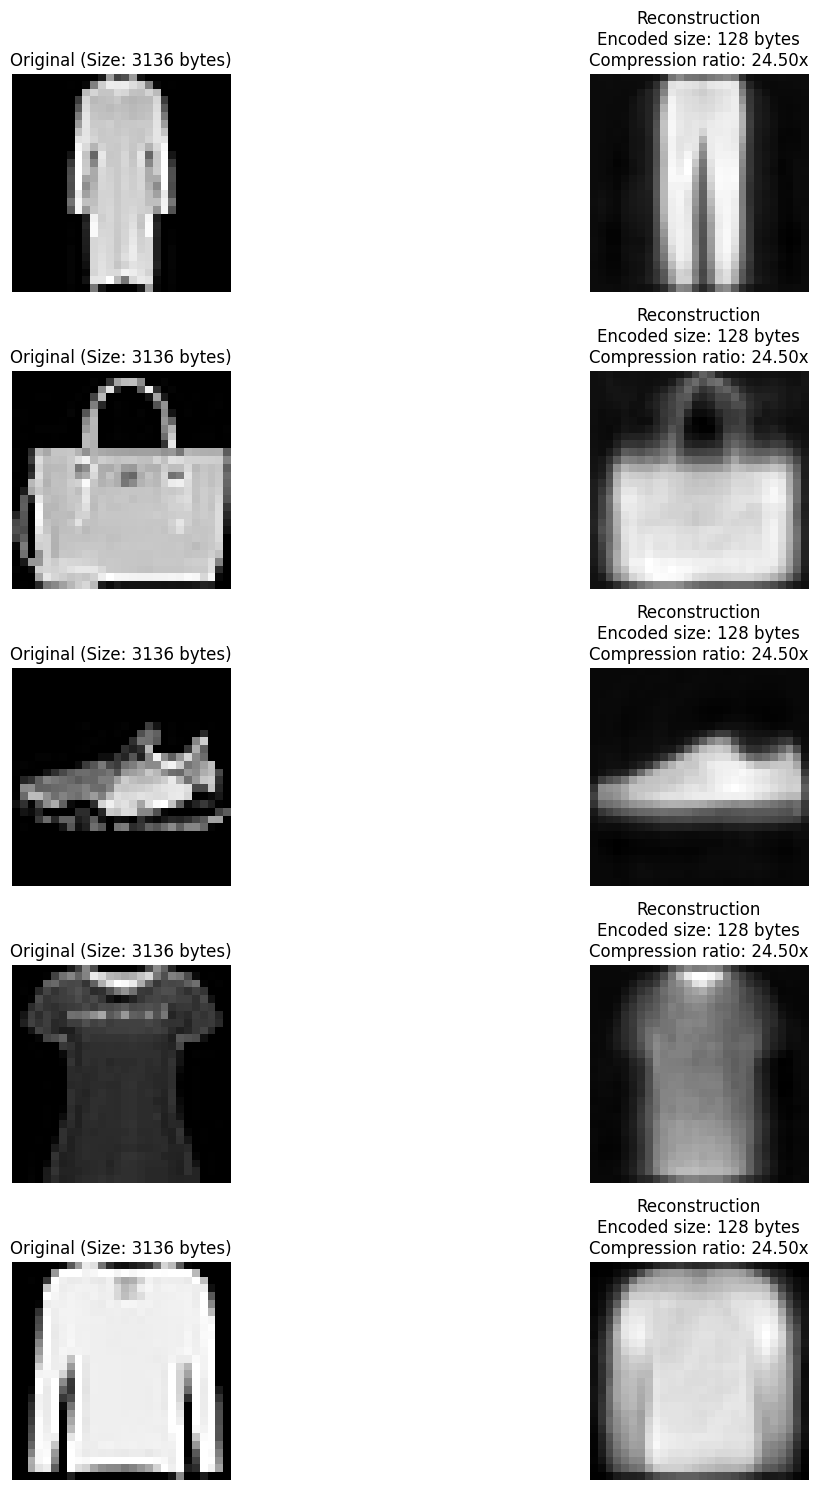

In [156]:
# We specifies ids of images from the test set.
#IMG_IDs = [13, 36, 60, 80]
#IMG_IDs = [33, 66, 50, 30]
#IMG_IDs = [1, 2, 3, 4]
#IMG_IDs = [91, 31, 41, 73] #best reconstruction
#IMG_IDs = [92, 93, 94, 95]
#IMG_IDs = [51, 52, 53, 54, 99]
#IMG_IDs = [55, 56, 57, 58, 59]
#IMG_IDs = [61, 62, 63, 64, 65]
IMG_IDs = [67, 69, 70, 71, 72]
#IMG_IDs = np.random.randint(0, 99, 5)

# samples
z_sampled = model.entropy_coding.sample(quantizer=model.quantizer, B=9)
x_sampled = model.decoder(z_sampled)

# reconstructions
x_real = torch.stack([test_data.__getitem__(x) for x in IMG_IDs]).to(device)
z_encoded = model.encoder(x_real)
x_rec = model.decoder(model.quantizer(z_encoded)[-1])

# plotting
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
for i in range(len(IMG_IDs)):
    # Original image
    original_img = x_real[i].cpu().reshape(28,28).detach().numpy()
    axs[i,0].imshow(original_img, cmap ='gray')
    original_size = original_img.nbytes
    axs[i,0].set_title(f'Original (Size: {original_size} bytes)')
    axs[i,0].axis('off')

    # Encoded representation
    encoded_size = z_encoded[i].cpu().numel() * z_encoded[i].element_size()  # Size in bytes
    compression_ratio = original_size / encoded_size
    
    # Reconstructed image (for visualization)
    reconstructed_img = x_rec[i].cpu().reshape(28,28).detach().numpy()
    axs[i,1].imshow(reconstructed_img, cmap='gray')
    axs[i,1].set_title(f'Reconstruction\nEncoded size: {encoded_size} bytes\nCompression ratio: {compression_ratio:.2f}x')
    axs[i,1].axis('off')

plt.tight_layout()
plt.savefig(result_dir + name + 'recon_sample.pdf', bbox_inches='tight')